# Convolutional  Neural Network

## CNN

* 이미지 분류를 위한 특별한 구조의 Deep Neural Network

 * local receptive fields
 * shared weights
 * pooling

## Local Receptive Field


* Input Layer의 일부 Input에 대해서만 다음 Hidden Layer로 weight 연결
 * 예: 28x28 Input Layer에서 5x5 영역에 대해서만 weight 연결 
 * => 다음 Hidden Layer의 크기는 (28-5+1)x(28-5+1) = 24x24
 * Sparse Connectivity
 

<img src="http://neuralnetworksanddeeplearning.com/images/tikz44.png">
<img src="http://neuralnetworksanddeeplearning.com/images/tikz45.png">


* http://cs231n.github.io/assets/conv-demo/index.html

## Shared weights and biases

* 모든 연결에 대해 공통 weight & bias 계수 사용
 * 위 예에서 parameter의 수는 26개 (5x5+1)
 
$$
\begin{eqnarray} 
  \sigma\left(b + \sum_{l=0}^4 \sum_{m=0}^4  w_{l,m} a_{j+l, k+m} \right).
\end{eqnarray}
$$


* 이 연산은 2-D image filter의 convolution연산과 동일 
 * => Convolution NN
 * 공통 weight: image kernel, image filter

## Image Filter

<img src="http://i.stack.imgur.com/GvsBA.jpg">

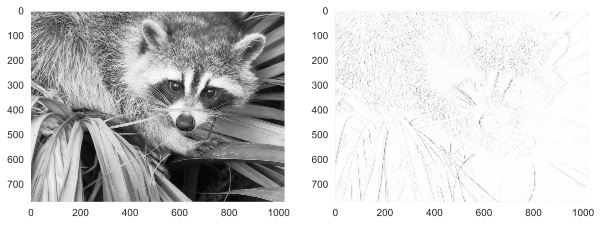

In [1]:
import scipy.ndimage
img = 255 - sp.misc.face(gray=True).astype(float)
k = np.zeros((2,2))
k[:,0] = 1; k[:,1] = -1
img2 = np.maximum(0, sp.ndimage.filters.convolve(img, k))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img)
plt.grid(False)
plt.subplot(122)
plt.imshow(img2)
plt.grid(False)

## Feature Map

* 만약 weight가 특정 image patter에 대해 a=1인 출력을 내도록 training 되었다면 
 * hidden layer는 feature가 존재하는 위치를 표시
 * => feature map
* 여기에서의 feature는 input data를 의미하는 것이 아니라 image 분류에 사용되는 input data의 특정한 pattern을 뜻함


<img src="http://www.kdnuggets.com/wp-content/uploads/computer-vision-filters.jpg">



## Multiple Feature Maps

* 하나의 공통 weight set은 한 종류의 image feature만 발견 가능
* 복수의 feature map (weight set) 필요

<img src="http://neuralnetworksanddeeplearning.com/images/tikz46.png"> 


* MNIST digit image 에 대해 training이 완료된 20개 feature map의 예

<img src="http://neuralnetworksanddeeplearning.com/images/net_full_layer_0.png" style="width:50%;"> 


<img src="http://i.ytimg.com/vi/n6hpQwq7Inw/maxresdefault.jpg">

## Max Pooling Layer

* 영역내에서 가장 최대값 출력
 * 영역내에 feature가 존재하는지의 여부
 * 전체 영역이 축소 
 
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" style="width:50%;"> 



<img src="http://neuralnetworksanddeeplearning.com/images/tikz48.png">

## L2 pooling

* maximum 값 대신에 영역내의 값의 sum of square 사용

## Output Layer

* softmax 

<img src="http://neuralnetworksanddeeplearning.com/images/tikz49.png">

## Demo

* http://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html

## Python Implementation

* https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network3.py

```python
class FullyConnectedLayer(object):

    def __init__(self, n_in, n_out, activation_fn=sigmoid, p_dropout=0.0):
        self.n_in = n_in
        self.n_out = n_out
        self.activation_fn = activation_fn
        self.p_dropout = p_dropout
        # Initialize weights and biases
        self.w = theano.shared(
            np.asarray(
                np.random.normal(
                    loc=0.0, scale=np.sqrt(1.0/n_out), size=(n_in, n_out)),
                dtype=theano.config.floatX),
            name='w', borrow=True)
        self.b = theano.shared(
            np.asarray(np.random.normal(loc=0.0, scale=1.0, size=(n_out,)),
                       dtype=theano.config.floatX),
            name='b', borrow=True)
        self.params = [self.w, self.b]

    def set_inpt(self, inpt, inpt_dropout, mini_batch_size):
        self.inpt = inpt.reshape((mini_batch_size, self.n_in))
        self.output = self.activation_fn(
            (1-self.p_dropout)*T.dot(self.inpt, self.w) + self.b)
        self.y_out = T.argmax(self.output, axis=1)
        self.inpt_dropout = dropout_layer(
            inpt_dropout.reshape((mini_batch_size, self.n_in)), self.p_dropout)
        self.output_dropout = self.activation_fn(
            T.dot(self.inpt_dropout, self.w) + self.b)

    def accuracy(self, y):
        "Return the accuracy for the mini-batch."
        return T.mean(T.eq(y, self.y_out))
```        

```python
class ConvPoolLayer(object):
    """Used to create a combination of a convolutional and a max-pooling
    layer.  A more sophisticated implementation would separate the
    two, but for our purposes we'll always use them together, and it
    simplifies the code, so it makes sense to combine them.

    """

    def __init__(self, filter_shape, image_shape, poolsize=(2, 2),
                 activation_fn=sigmoid):
        """`filter_shape` is a tuple of length 4, whose entries are the number
        of filters, the number of input feature maps, the filter height, and the
        filter width.

        `image_shape` is a tuple of length 4, whose entries are the
        mini-batch size, the number of input feature maps, the image
        height, and the image width.

        `poolsize` is a tuple of length 2, whose entries are the y and
        x pooling sizes.

        """
        self.filter_shape = filter_shape
        self.image_shape = image_shape
        self.poolsize = poolsize
        self.activation_fn=activation_fn
        # initialize weights and biases
        n_out = (filter_shape[0]*np.prod(filter_shape[2:])/np.prod(poolsize))
        self.w = theano.shared(
            np.asarray(
                np.random.normal(loc=0, scale=np.sqrt(1.0/n_out), size=filter_shape),
                dtype=theano.config.floatX),
            borrow=True)
        self.b = theano.shared(
            np.asarray(
                np.random.normal(loc=0, scale=1.0, size=(filter_shape[0],)),
                dtype=theano.config.floatX),
            borrow=True)
        self.params = [self.w, self.b]

    def set_inpt(self, inpt, inpt_dropout, mini_batch_size):
        self.inpt = inpt.reshape(self.image_shape)
        conv_out = conv.conv2d(
            input=self.inpt, filters=self.w, filter_shape=self.filter_shape,
            image_shape=self.image_shape)
        pooled_out = downsample.max_pool_2d(
            input=conv_out, ds=self.poolsize, ignore_border=True)
        self.output = self.activation_fn(
            pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))
        self.output_dropout = self.output # no dropout in the convolutional layers
```

```python
class SoftmaxLayer(object):

    def __init__(self, n_in, n_out, p_dropout=0.0):
        self.n_in = n_in
        self.n_out = n_out
        self.p_dropout = p_dropout
        # Initialize weights and biases
        self.w = theano.shared(
            np.zeros((n_in, n_out), dtype=theano.config.floatX),
            name='w', borrow=True)
        self.b = theano.shared(
            np.zeros((n_out,), dtype=theano.config.floatX),
            name='b', borrow=True)
        self.params = [self.w, self.b]

    def set_inpt(self, inpt, inpt_dropout, mini_batch_size):
        self.inpt = inpt.reshape((mini_batch_size, self.n_in))
        self.output = softmax((1-self.p_dropout)*T.dot(self.inpt, self.w) + self.b)
        self.y_out = T.argmax(self.output, axis=1)
        self.inpt_dropout = dropout_layer(
            inpt_dropout.reshape((mini_batch_size, self.n_in)), self.p_dropout)
        self.output_dropout = softmax(T.dot(self.inpt_dropout, self.w) + self.b)

    def cost(self, net):
        "Return the log-likelihood cost."
        return -T.mean(T.log(self.output_dropout)[T.arange(net.y.shape[0]), net.y])

    def accuracy(self, y):
        "Return the accuracy for the mini-batch."
        return T.mean(T.eq(y, self.y_out))

```

```python
class Network(object):
    
    def __init__(self, layers, mini_batch_size):
        """Takes a list of `layers`, describing the network architecture, and
        a value for the `mini_batch_size` to be used during training
        by stochastic gradient descent.

        """
        self.layers = layers
        self.mini_batch_size = mini_batch_size
        self.params = [param for layer in self.layers for param in layer.params]
        self.x = T.matrix("x")  
        self.y = T.ivector("y")
        init_layer = self.layers[0]
        init_layer.set_inpt(self.x, self.x, self.mini_batch_size)
        for j in xrange(1, len(self.layers)):
            prev_layer, layer  = self.layers[j-1], self.layers[j]
            layer.set_inpt(
                prev_layer.output, prev_layer.output_dropout, self.mini_batch_size)
        self.output = self.layers[-1].output
        self.output_dropout = self.layers[-1].output_dropout


    def SGD(self, training_data, epochs, mini_batch_size, eta,
            validation_data, test_data, lmbda=0.0):
        """Train the network using mini-batch stochastic gradient descent."""
        training_x, training_y = training_data
        validation_x, validation_y = validation_data
        test_x, test_y = test_data

        # compute number of minibatches for training, validation and testing
        num_training_batches = size(training_data)/mini_batch_size
        num_validation_batches = size(validation_data)/mini_batch_size
        num_test_batches = size(test_data)/mini_batch_size

        # define the (regularized) cost function, symbolic gradients, and updates
        l2_norm_squared = sum([(layer.w**2).sum() for layer in self.layers])
        cost = self.layers[-1].cost(self)+\
               0.5*lmbda*l2_norm_squared/num_training_batches
        grads = T.grad(cost, self.params)
        updates = [(param, param-eta*grad)
                   for param, grad in zip(self.params, grads)]

        # define functions to train a mini-batch, and to compute the
        # accuracy in validation and test mini-batches.
        i = T.lscalar() # mini-batch index
        train_mb = theano.function(
            [i], cost, updates=updates,
            givens={
                self.x:
                training_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size],
                self.y:
                training_y[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        validate_mb_accuracy = theano.function(
            [i], self.layers[-1].accuracy(self.y),
            givens={
                self.x:
                validation_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size],
                self.y:
                validation_y[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        test_mb_accuracy = theano.function(
            [i], self.layers[-1].accuracy(self.y),
            givens={
                self.x:
                test_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size],
                self.y:
                test_y[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        self.test_mb_predictions = theano.function(
            [i], self.layers[-1].y_out,
            givens={
                self.x:
                test_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        # Do the actual training
        best_validation_accuracy = 0.0
        for epoch in xrange(epochs):
            for minibatch_index in xrange(num_training_batches):
                iteration = num_training_batches*epoch+minibatch_index
                if iteration % 1000 == 0:
                    print("Training mini-batch number {0}".format(iteration))
                cost_ij = train_mb(minibatch_index)
                if (iteration+1) % num_training_batches == 0:
                    validation_accuracy = np.mean(
                        [validate_mb_accuracy(j) for j in xrange(num_validation_batches)])
                    print("Epoch {0}: validation accuracy {1:.2%}".format(
                        epoch, validation_accuracy))
                    if validation_accuracy >= best_validation_accuracy:
                        print("This is the best validation accuracy to date.")
                        best_validation_accuracy = validation_accuracy
                        best_iteration = iteration
                        if test_data:
                            test_accuracy = np.mean(
                                [test_mb_accuracy(j) for j in xrange(num_test_batches)])
                            print('The corresponding test accuracy is {0:.2%}'.format(
                                test_accuracy))
        print("Finished training network.")
        print("Best validation accuracy of {0:.2%} obtained at iteration {1}".format(
            best_validation_accuracy, best_iteration))
        print("Corresponding test accuracy of {0:.2%}".format(test_accuracy))
```        

## Performance Test

In [2]:
%cd /home/dockeruser/neural-networks-and-deep-learning/src

/home/dockeruser/neural-networks-and-deep-learning/src


## Normal MLP

In [3]:
import network3
from network3 import Network
from network3 import ConvPoolLayer, FullyConnectedLayer, SoftmaxLayer

training_data, validation_data, test_data = network3.load_data_shared()
mini_batch_size = 10

net = Network([
            FullyConnectedLayer(n_in=784, n_out=100),
            SoftmaxLayer(n_in=100, n_out=10)], 
            mini_batch_size)

net.SGD(training_data, 10, mini_batch_size, 0.1, validation_data, test_data)

Trying to run under a GPU.  If this is not desired, then modify network3.py
to set the GPU flag to False.


/home/dockeruser/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Training mini-batch number 0
Training mini-batch number 1000
Training mini-batch number 2000
Training mini-batch number 3000
Training mini-batch number 4000
Epoch 0: validation accuracy 92.77%
This is the best validation accuracy to date.
The corresponding test accuracy is 92.07%
Training mini-batch number 5000
Training mini-batch number 6000
Training mini-batch number 7000
Training mini-batch number 8000
Training mini-batch number 9000
Epoch 1: validation accuracy 94.83%
This is the best validation accuracy to date.
The corresponding test accuracy is 94.26%
Training mini-batch number 10000
Training mini-batch number 11000
Training mini-batch number 12000
Training mini-batch number 13000
Training mini-batch number 14000
Epoch 2: validation accuracy 95.82%
This is the best validation accuracy to date.
The corresponding test accuracy is 95.32%
Training mini-batch number 15000
Training mini-batch number 16000
Training mini-batch number 17000
Training mini-batch number 18000
Training mini-

## Add Convolutional + Pooling Layer

In [4]:
net = Network([
        ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28), 
                      filter_shape=(20, 1, 5, 5), 
                      poolsize=(2, 2)),
        FullyConnectedLayer(n_in=20*12*12, n_out=100),
        SoftmaxLayer(n_in=100, n_out=10)], 
        mini_batch_size)

net.SGD(training_data, 10, mini_batch_size, 0.1, validation_data, test_data)   

Training mini-batch number 0
Training mini-batch number 1000
Training mini-batch number 2000
Training mini-batch number 3000
Training mini-batch number 4000
Epoch 0: validation accuracy 94.03%
This is the best validation accuracy to date.
The corresponding test accuracy is 93.32%
Training mini-batch number 5000
Training mini-batch number 6000
Training mini-batch number 7000
Training mini-batch number 8000
Training mini-batch number 9000
Epoch 1: validation accuracy 96.28%
This is the best validation accuracy to date.
The corresponding test accuracy is 95.73%
Training mini-batch number 10000
Training mini-batch number 11000
Training mini-batch number 12000
Training mini-batch number 13000
Training mini-batch number 14000
Epoch 2: validation accuracy 97.20%
This is the best validation accuracy to date.
The corresponding test accuracy is 96.76%
Training mini-batch number 15000
Training mini-batch number 16000
Training mini-batch number 17000
Training mini-batch number 18000
Training mini-

## Add Additional Convolution + Pool Layer

* 두번째 convolutional-pooling layer의 역할
 * feature map에서 feature가 나타나는 pattern의 포착
 * feature of feature map


In [5]:
net = Network([
        ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28), 
                      filter_shape=(20, 1, 5, 5), 
                      poolsize=(2, 2)),
        ConvPoolLayer(image_shape=(mini_batch_size, 20, 12, 12), 
                      filter_shape=(40, 20, 5, 5), 
                      poolsize=(2, 2)),
        FullyConnectedLayer(n_in=40*4*4, n_out=100),
        SoftmaxLayer(n_in=100, n_out=10)], 
        mini_batch_size)

net.SGD(training_data, 10, mini_batch_size, 0.1, validation_data, test_data)

Training mini-batch number 0
Training mini-batch number 1000
Training mini-batch number 2000
Training mini-batch number 3000
Training mini-batch number 4000
Epoch 0: validation accuracy 90.78%
This is the best validation accuracy to date.
The corresponding test accuracy is 90.35%
Training mini-batch number 5000
Training mini-batch number 6000
Training mini-batch number 7000
Training mini-batch number 8000
Training mini-batch number 9000
Epoch 1: validation accuracy 96.71%
This is the best validation accuracy to date.
The corresponding test accuracy is 96.48%
Training mini-batch number 10000
Training mini-batch number 11000
Training mini-batch number 12000
Training mini-batch number 13000
Training mini-batch number 14000
Epoch 2: validation accuracy 97.47%
This is the best validation accuracy to date.
The corresponding test accuracy is 97.18%
Training mini-batch number 15000
Training mini-batch number 16000
Training mini-batch number 17000
Training mini-batch number 18000
Training mini-

## Apply ReLu

* sigmoid activation functions 보다 성능 향상

In [6]:
from network3 import ReLU

net = Network([
        ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28), 
                      filter_shape=(20, 1, 5, 5), 
                      poolsize=(2, 2), 
                      activation_fn=ReLU),
        ConvPoolLayer(image_shape=(mini_batch_size, 20, 12, 12), 
                      filter_shape=(40, 20, 5, 5), 
                      poolsize=(2, 2), 
                      activation_fn=ReLU),
        FullyConnectedLayer(n_in=40*4*4, n_out=100, activation_fn=ReLU),
        SoftmaxLayer(n_in=100, n_out=10)], 
        mini_batch_size)

net.SGD(training_data, 60, mini_batch_size, 0.03, validation_data, test_data, lmbda=0.1)

Training mini-batch number 0
Training mini-batch number 1000
Training mini-batch number 2000
Training mini-batch number 3000
Training mini-batch number 4000
Epoch 0: validation accuracy 97.62%
This is the best validation accuracy to date.
The corresponding test accuracy is 97.21%
Training mini-batch number 5000
Training mini-batch number 6000
Training mini-batch number 7000
Training mini-batch number 8000
Training mini-batch number 9000
Epoch 1: validation accuracy 98.00%
This is the best validation accuracy to date.
The corresponding test accuracy is 97.88%
Training mini-batch number 10000
Training mini-batch number 11000
Training mini-batch number 12000
Training mini-batch number 13000
Training mini-batch number 14000
Epoch 2: validation accuracy 98.08%
This is the best validation accuracy to date.
The corresponding test accuracy is 98.22%
Training mini-batch number 15000
Training mini-batch number 16000
Training mini-batch number 17000
Training mini-batch number 18000
Training mini-

## History of CNN


### 1998 LeNet-5 paper
* "Gradient-based learning applied to document recognition"
* by Yann LeCun, Léon Bottou, Yoshua Bengio, and Patrick Haffner
* LeNet-5
 * MNIST digit image classification
  

###  2012 LRMD paper
* "Building high-level features using large scale unsupervised learning"
* by Quoc Le, Marc'Aurelio Ranzato, Rajat Monga, Matthieu Devin, Kai Chen, Greg Corrado, Jeff Dean, and Andrew Ng (2012). 
* Stanford and Google
* classify images from ImageNet
 * accuracy 9.3% -> 15.8%


* Image-Net
 * http://image-net.org/
 * 16 million full color images in 20 thousand categories
 * classified by Amazon's Mechanical Turk service


### 2012 KSH paper
* "ImageNet classification with deep convolutional neural networks"
* by Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton (2012).
* ImageNet Large-Scale Visual Recognition Challenge (ILSVRC)
 * training set: 1.2 million ImageNet images, drawn from 1,000 categories
 * validation and test sets: 50,000 and 150,000 images from the same 1,000 categories
 * some contain multiple objects
 * accuracy 84.7%
* AlexNet
 * Input Layer: 3×224×224 neurons, (RGB values for a 224×224 image)
 * 77 hidden layers of  neurons
    * first 55 hidden layers are convolutional layers (some with max-pooling), 
    * next 22 layers are fully-connected layers
 * The ouput layer is a 1,000-unit softmax layer
 * ReLU (rectified linear units)
 * parameters: 60 million
 * l2 regularization and dropout
 * momentum-based mini-batch stochastic gradient descent
 
 
<img src="http://neuralnetworksanddeeplearning.com/images/KSH.jpg">


### 2014 ILSVRC competition
* training set of 1.2 million images, in 1,000 categories
* GoogLeNet
 * 22 layers Deep CNN
 * 93.33% 